# Hybrid model for energy demand in France

First predict demand using only climate variables.
Then, train a model on the predictions using non-climate stuff like weekends, month etc.

In [1]:
import os
import glob
import xarray as xr
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import LeaveOneGroupOut
# from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error
from sklearn.inspection import permutation_importance

from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from scipy.stats import pearsonr, randint, uniform
from scipy.spatial.distance import correlation

import matplotlib.pyplot as plt

### Note:

You will need to change the kernel to ml_env to use `mlxtend`

In [2]:
%cd /g/data/w42/dr6273/work/demand_model/

import functions as fn

/g/data/w42/dr6273/work/demand_model


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
path = "/g/data/w42/dr6273/work/projects/Aus_energy/"

In [5]:
region = "FR"

### Demand

In [6]:
demand = pd.read_csv(
    "/g/data/w42/dr6273/work/data/ENTSOE/ENTSOE_daily_demand_2006-2018.csv",
    index_col=0,
    parse_dates=True
)

In [7]:
demand = demand[demand["Country"] == region]["Power (MWh/day)"]

In [8]:
dem_da = xr.DataArray(
    demand.squeeze(),
    dims=["time"],
    coords={"time": demand.index.values}
)

In [9]:
dem_da = dem_da.expand_dims({"region": [region]})

In [10]:
dem_da = fn.detrend_dim(dem_da, "time") + dem_da.mean("time")

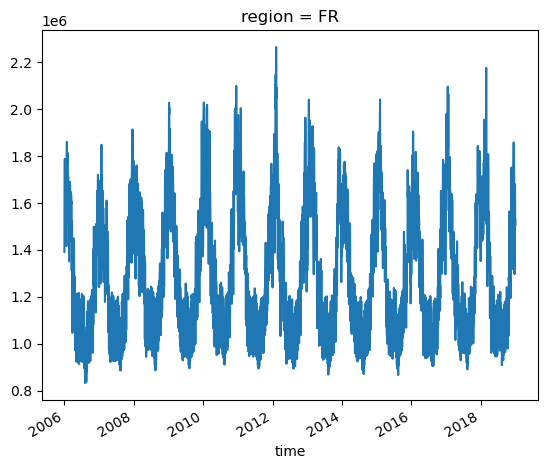

In [11]:
dem_da.plot()

### Predictors

In [168]:
files = fn.get_predictor_files(region, "pop_dens_mask")

In [169]:
pred_ds = xr.open_mfdataset(files, combine="nested", compat="override").compute()

In [170]:
pred_ds.data_vars

Data variables:
    msdwswrf  (time) float64 44.56 43.21 51.47 53.18 ... 31.66 34.83 29.22 37.78
    w10       (time) float64 4.219 4.438 3.654 3.395 ... 4.548 4.841 4.735 4.957
    t2m       (time) float64 279.4 278.4 277.2 275.8 ... 279.8 280.6 281.0 283.6
    cdd       (time) float64 0.02074 0.02073 0.02073 ... -0.02073 -0.02074
    hdd       (time) float64 8.808 9.803 11.03 12.42 ... 8.312 7.498 7.14 4.48
    rh        (time) float64 83.3 82.79 82.81 81.51 ... 85.94 82.65 86.8 81.35
    t2min     (time) float64 nan 275.6 274.4 272.7 ... 276.8 277.7 277.4 280.6
    mtpr      (time) float64 2.423e-05 5.883e-05 ... 4.854e-05 5.122e-05
    q         (time) float64 5.097 4.794 4.397 3.954 ... 5.48 5.54 5.976 6.661
    t2max     (time) float64 nan 280.8 279.0 278.0 ... 282.4 282.6 283.8 285.9

In [171]:
pred_ds = pred_ds.expand_dims({"region": [region]})

## Prepare data

In [172]:
time_cols = []

region_dfs = {}
for region in dem_da.region.values:
    df = fn.to_dataframe(dem_da, pred_ds, region)
    for t in time_cols:
        df = fn.add_time_column(df, t)
    new_cols = np.append(np.append("demand", time_cols), df.columns[:-(len(time_cols) + 1)])
    df = df[new_cols]
    region_dfs[region] = df

In [173]:
region_dfs[region]

,demand,msdwswrf,w10,t2m,cdd,hdd,rh,t2min,mtpr,q,t2max
2006-01-01,1.390770e+06,33.469701,2.968107,277.120854,-0.009722,11.013986,87.793425,274.126953,0.000044,4.606783,278.299142
2006-01-02,1.558161e+06,38.620781,2.234833,276.025270,-0.009723,12.109568,88.337877,272.778723,0.000021,4.223533,277.842970
2006-01-03,1.680000e+06,38.505117,1.849658,275.761280,-0.009725,12.373554,87.220708,272.670548,0.000014,4.090290,277.582042
2006-01-04,1.723594e+06,40.630597,2.490590,274.708175,-0.009727,13.426657,86.078723,271.983277,0.000009,3.725595,276.859842
2006-01-05,1.787870e+06,38.203008,2.962313,274.200237,-0.009729,13.934592,84.712166,271.639411,0.000008,3.543822,276.056212
...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,1.679940e+06,40.692448,1.612725,275.848274,-0.018136,12.273452,87.795194,273.492140,0.000002,4.168545,279.485340
2018-12-28,1.669453e+06,38.997165,1.929787,276.401266,-0.018138,11.720458,89.504321,273.725989,0.000002,4.416365,279.349883
2018-12-29,1.591212e+06,36.062917,3.070928,277.571661,-0.018140,10.550060,88.539303,274.841585,0.000012,4.729524,280.415372
2018-12-30,1.501771e+06,36.289060,3.001991,278.441629,-0.018142,9.680090,86.732386,275.520617,0.000011,4.884352,280.783025


## Split data into training and testing

Using this as a guide: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

As this is time series data, leave out the last two years for testing.

In [174]:
first_train_year = 2006
last_train_year = 2013

In [175]:
first_test_year = 2014
last_test_year = 2016

In [176]:
# Hold out last X years for testing
test_len = dem_da.sel(time=slice(str(first_test_year), str(last_test_year))).time.values.shape[0]

In [177]:
test_len

1096

In [178]:
def sel_train_test(df, first_train_year, last_test_year):
    """
    Selects df for training and test years. Might be used to e.g.
    exclude a validation set.
    """
    return df[(df.index.year >= first_train_year) & (df.index.year <= last_test_year)]

In [179]:
train_X, test_X, train_y, test_y = fn.split(
    sel_train_test(region_dfs[region], first_train_year, last_test_year),
    "demand",
    test_size=test_len,
    random_state=0,
    shuffle=False
)

## Sequential feature selection

Chooses the predictors using forwards selection and a stopping criterion for a score.

In [180]:
# rf = RandomForestRegressor(
#     n_estimators=best_params["n_estimators"],
#     random_state=0
# )

In [181]:
# rf = ExtraTreesRegressor(
#     random_state=0
# )

In [182]:
# logo = fn.leave_one_group_out(train_X, train_y, dem_da, str(first_train_year), str(last_train_year))

In [183]:
# %%time
# model = fn.mlextend_sfs(train_X, train_y, rf, list(logo), True, scoring="neg_mean_absolute_error")

In [184]:
# model.subsets_

In [185]:
# model.k_feature_idx_

In [186]:
# selected_features = list(region_dfs[region].columns[1:][list(model.k_feature_idx_)])
# print(selected_features)

In [187]:
# Once we know the selected features, we can just input them to save running the model again
selected_features = ['msdwswrf', 'w10', 'cdd', 'hdd', 'rh', 't2min', 'mtpr', 'q', 't2max']

In [168]:
pd.DataFrame.from_dict(model.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(4,)","[-113995.28018003576, -109533.98818052307, -11...",-110711.802003,"(4,)",3248.477536,3727.080784,1408.704124
2,"(0, 4)","[-95455.32220345488, -86506.27952405535, -1004...",-95208.329031,"(0, 4)",3847.425091,4414.272214,1668.438071
3,"(0, 3, 4)","[-87610.87536416519, -86880.91304896487, -9559...",-90808.97154,"(0, 3, 4)",3548.197532,4070.958994,1538.677871
4,"(0, 3, 4, 7)","[-85502.22344603106, -83048.5391757356, -92256...",-88839.71934,"(0, 3, 4, 7)",4092.302832,4695.228173,1774.629442
5,"(0, 3, 4, 6, 7)","[-86202.69624077773, -84862.03041390465, -9193...",-88329.002824,"(0, 3, 4, 6, 7)",3729.073379,4278.48356,1617.114784
6,"(0, 3, 4, 5, 6, 7)","[-85449.3388912178, -84195.85687611977, -91702...",-87765.366537,"(0, 3, 4, 5, 6, 7)",3671.65929,4212.610564,1592.217132
7,"(0, 1, 3, 4, 5, 6, 7)","[-86845.19193226605, -82644.36114663839, -9168...",-87757.316523,"(0, 1, 3, 4, 5, 6, 7)",3591.741017,4120.917808,1557.560528
8,"(0, 1, 3, 4, 5, 6, 7, 8)","[-86583.81735594875, -83419.74780249195, -9252...",-88078.108389,"(0, 1, 3, 4, 5, 6, 7, 8)",3249.247633,3727.96434,1409.038077
9,"(0, 1, 3, 4, 5, 6, 7, 8, 9)","[-87028.15055676097, -83583.76063292165, -9221...",-88104.233637,"(0, 1, 3, 4, 5, 6, 7, 8, 9)",3723.249496,4271.801636,1614.589254
10,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)","[-87716.59292710753, -85673.64135361885, -9173...",-88210.507395,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",3468.479268,3979.495714,1504.108


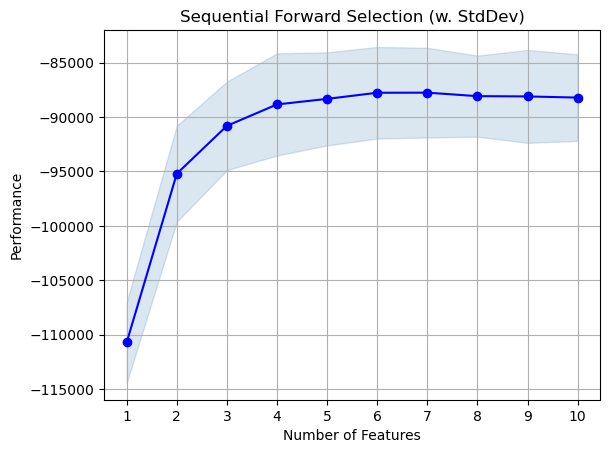

In [169]:
fig1 = plot_sfs(model.get_metric_dict(), kind='std_dev')
# plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

## Tune hyperparameters

Using leave one group out cross validation, where a group is a year.

In [188]:
parameters = {
    "n_estimators": randint(200, 500), # no. trees in the forest
    "min_samples_leaf": randint(5, 30), # min no. samples at leaf node
    "max_depth" : randint(5, 50), # max depth of each tree
    # "max_features" : uniform(0.2, 1) # max proportion of features to consider at split
    "max_leaf_nodes": randint(20, 100) # size of tree, how many end nodes
}

In [189]:
retain = ["demand"] + selected_features

In [190]:
final_features = region_dfs[region][retain]

In [191]:
final_features.head()

,demand,msdwswrf,w10,cdd,hdd,rh,t2min,mtpr,q,t2max
2006-01-01,1.390770e+06,33.469701,2.968107,-0.009722,11.013986,87.793425,274.126953,0.000044,4.606783,278.299142
2006-01-02,1.558161e+06,38.620781,2.234833,-0.009723,12.109568,88.337877,272.778723,0.000021,4.223533,277.842970
2006-01-03,1.680000e+06,38.505117,1.849658,-0.009725,12.373554,87.220708,272.670548,0.000014,4.090290,277.582042
2006-01-04,1.723594e+06,40.630597,2.490590,-0.009727,13.426657,86.078723,271.983277,0.000009,3.725595,276.859842
2006-01-05,1.787870e+06,38.203008,2.962313,-0.009729,13.934592,84.712166,271.639411,0.000008,3.543822,276.056212


In [192]:
train_X, test_X, train_y, test_y = fn.split(
    sel_train_test(final_features, first_train_year, last_test_year),
    "demand",
    test_size=test_len,
    random_state=0,
    shuffle=False
)

In [193]:
# rf = ExtraTreesRegressor()

In [194]:
# logo = fn.leave_one_group_out(train_X, train_y, dem_da, str(first_train_year), str(last_train_year))

In [195]:
# %%time
# best_params = fn.tune_hyperparameters(
#     train_X,
#     train_y,
#     rf,
#     parameters,
#     logo,
#     n_iter=200
# )

In [197]:
# best_params

## Finalise model

In [198]:
# to save tuning hyperparameters again, copy and paste best_params here
best_params = dict(
    max_depth=30,
    max_leaf_nodes=97,
    min_samples_leaf=13,
    n_estimators=465
)

In [199]:
rf = ExtraTreesRegressor(
    n_estimators=best_params["n_estimators"],
    min_samples_leaf=best_params["min_samples_leaf"],
    max_depth=best_params["max_depth"],
    max_leaf_nodes=best_params["max_leaf_nodes"],
    random_state=0,
)

In [200]:
model_train, pred_train = fn.predict_forest(train_y, train_X, train_X, rf)

In [201]:
model_test, pred_test = fn.predict_forest(train_y, train_X, test_X, rf)

In [202]:
pred_train.shape

(2922,)

In [203]:
pred_test.shape

(1096,)

## Evaluate performance

In [204]:
metric_names = ["R2", "MAE", "MSE", "MAPE", "MedAE"]
metrics = [r2_score, mean_absolute_error,
           mean_squared_error, mean_absolute_percentage_error, median_absolute_error]

In [205]:
train_scores = fn.compute_scores(train_y, pred_train, metrics)

In [206]:
train_scores

[0.8758203704904577,
 79010.11452973621,
 8815209446.827778,
 0.063069132687535,
 70385.85005082365]

In [207]:
test_scores = fn.compute_scores(test_y, pred_test, metrics)

In [208]:
test_scores

[0.8471874293724893,
 80618.97146089762,
 9219887062.316177,
 0.06481786067082755,
 71737.86914654123]

In [209]:
def plot_scores(train, test, metric_names):
    """
    Subplot for each metric showing score for train and test.
    """
    fig, ax = plt.subplots(2, 3, figsize=(6, 3))
    for i, a in enumerate(ax.flatten()):
        if i < len(metric_names):
            a.bar(["Train", "Test"], [train[i], test[i]])
            a.set_title(metric_names[i])
    plt.tight_layout()

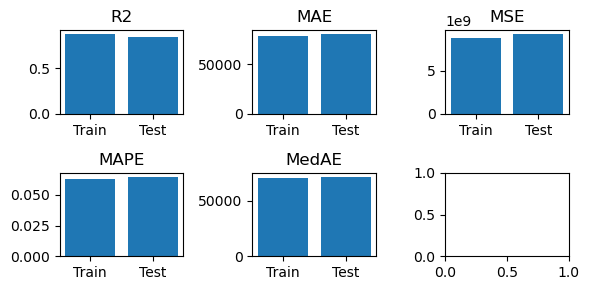

In [210]:
plot_scores(train_scores, test_scores, metric_names)

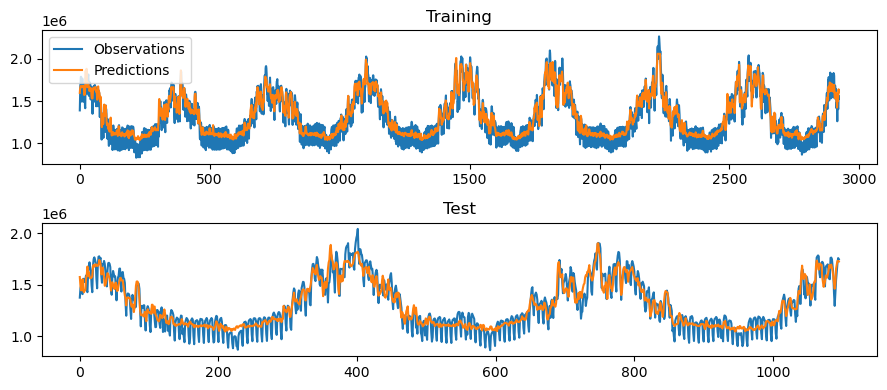

In [211]:
fig, ax = plt.subplots(2, 1, figsize=(9, 4))

ax[0].plot(train_y, label="Observations")
ax[0].plot(pred_train, label="Predictions")
ax[0].legend()
ax[0].set_title("Training")

ax[1].plot(test_y)
ax[1].plot(pred_test)
ax[1].set_title("Test")

plt.tight_layout()

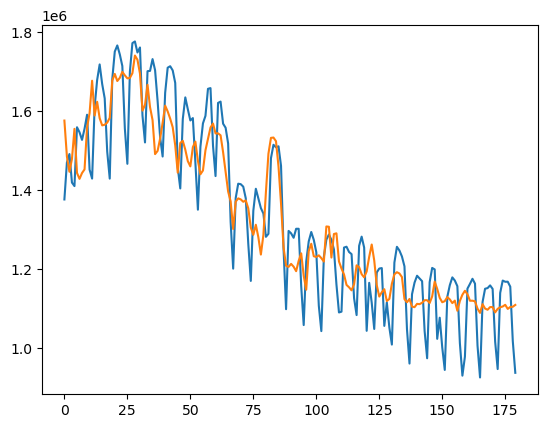

In [212]:
plt.plot(test_y[:180])
plt.plot(pred_test[:180])

## Permutation importances

Compute these on the training and test sets. Differences tell us what the model actually used to make the predictions.

In [58]:
perm_train = fn.perm_imp(
    model_train,
    train_X,
    train_y,
    n_repeats=2,
)

In [59]:
perm_test = fn.perm_imp(
    model_test,
    test_X,
    test_y,
    n_repeats=2,
)

In [60]:
perm_train

{'importances_mean': array([0.0293587 , 0.00313366, 0.01132232, 0.24218782, 0.00484521,
        0.06657404, 0.00345556, 0.01794737, 0.14732108]),
 'importances_std': array([1.54611815e-04, 6.14642522e-05, 3.04806378e-04, 3.96410979e-03,
        1.13639106e-04, 1.44591410e-04, 2.71117389e-04, 3.58578614e-04,
        2.94413472e-03]),
 'importances': array([[0.02951331, 0.02920409],
        [0.0030722 , 0.00319513],
        [0.01101752, 0.01162713],
        [0.23822371, 0.24615193],
        [0.00495885, 0.00473157],
        [0.06642945, 0.06671863],
        [0.00372668, 0.00318444],
        [0.01758879, 0.01830594],
        [0.14437695, 0.15026522]])}

In [61]:
perm_test

{'importances_mean': array([0.0315383 , 0.0010261 , 0.00454769, 0.2240624 , 0.00243431,
        0.05217082, 0.00056135, 0.01353518, 0.13587377]),
 'importances_std': array([1.76595739e-03, 8.37737949e-05, 5.62187640e-07, 4.96121241e-04,
        2.24234015e-04, 1.41948800e-04, 5.68613960e-05, 7.20453828e-04,
        6.41882087e-04]),
 'importances': array([[0.02977234, 0.03330426],
        [0.00110988, 0.00094233],
        [0.00454713, 0.00454825],
        [0.22455852, 0.22356628],
        [0.00265854, 0.00221007],
        [0.05202887, 0.05231277],
        [0.00061821, 0.00050449],
        [0.01425563, 0.01281473],
        [0.13651565, 0.13523188]])}

In [62]:
fn.print_perm_imp(perm_train, selected_features)

hdd      0.242 +/- 0.004
t2max    0.147 +/- 0.003
t2min    0.067 +/- 0.000
msdwswrf 0.029 +/- 0.000
q        0.018 +/- 0.000
cdd      0.011 +/- 0.000
rh       0.005 +/- 0.000
mtpr     0.003 +/- 0.000
w10      0.003 +/- 0.000


In [63]:
fn.print_perm_imp(perm_test, selected_features)

hdd      0.224 +/- 0.000
t2max    0.136 +/- 0.001
t2min    0.052 +/- 0.000
msdwswrf 0.032 +/- 0.002
q        0.014 +/- 0.001
cdd      0.005 +/- 0.000
rh       0.002 +/- 0.000
w10      0.001 +/- 0.000
mtpr     0.001 +/- 0.000


# Non-weather model

Only use selected features

In [214]:
# selected_features

In [215]:
# retained_preds = pred_ds[selected_features]

In [216]:
# retained_preds

Instead of demand as target, use predictions from previous model

In [220]:
# first_train_year

In [221]:
# pred_train.shape

In [222]:
# pred_test.shape

In [223]:
# dem_da.sel(time=slice(str(first_train_year), str(last_test_year)))

In [224]:
# pred_da = xr.DataArray(
#     np.append(pred_train, pred_test).reshape(dem_da.sel(time=slice(str(first_train_year), str(last_test_year))).values.shape),
#     coords=dem_da.sel(time=slice(str(first_train_year), str(last_test_year))).coords,
#     dims=dem_da.sel(time=slice(str(first_train_year), str(last_test_year))).dims
# )

In [225]:
# pred_da

In [226]:
df = pd.DataFrame(
    dem_da.sel(time=slice(str(first_train_year), str(last_test_year)), region=region).values,
    index=sel_train_test(region_dfs[region], first_train_year, last_test_year).index,
    columns=["demand"]
)

In [227]:
df["pred"] = np.append(pred_train, pred_test)

In [228]:
time_cols = ["is_weekend", "month_int"]
for t in time_cols:
    df = fn.add_time_column(df, t)

In [229]:
df

,demand,pred,is_weekend,month_int
2006-01-01,1.390770e+06,1.597828e+06,1,1
2006-01-02,1.558161e+06,1.644092e+06,0,1
2006-01-03,1.680000e+06,1.652778e+06,0,1
2006-01-04,1.723594e+06,1.671403e+06,0,1
2006-01-05,1.787870e+06,1.678984e+06,0,1
...,...,...,...,...
2016-12-27,1.547058e+06,1.656260e+06,0,12
2016-12-28,1.625044e+06,1.697470e+06,0,12
2016-12-29,1.708560e+06,1.730227e+06,0,12
2016-12-30,1.758649e+06,1.730038e+06,0,12


In [232]:
# # time_cols = ["is_weekend", "month_sin", "month_cos"]
# time_cols = ["is_weekend", "month_int"]
# # time_cols = ["is_weekend", "season_int"]
# # time_cols = ["is_weekend", "is_transition"]
# # time_cols = ["is_weekend"]
# # time_cols = []

# region_dfs = {}
# for region in pred_da.region.values:
#     df = fn.to_dataframe(pred_da, retained_preds, region)
#     for t in time_cols:
#         df = fn.add_time_column(df, t)
#     new_cols = np.append(np.append("demand", time_cols), df.columns[:-(len(time_cols) + 1)])
#     df = df[new_cols]
#     region_dfs[region] = df

In [233]:
# region_dfs[region]

In [234]:
train_X, test_X, train_y, test_y = fn.split(
    sel_train_test(df, first_train_year, last_test_year),
    "demand",
    test_size=test_len,
    random_state=0,
    shuffle=False
)

In [235]:
rf = ExtraTreesRegressor(
    random_state=0
)

In [236]:
logo = fn.leave_one_group_out(train_X, train_y, dem_da, str(first_train_year), str(last_train_year))

[2006 2006 2006 ... 2013 2013 2013]


In [237]:
%%time
model = fn.mlextend_sfs(train_X, train_y, rf, list(logo), True, scoring="neg_mean_absolute_error")

CPU times: user 9.68 s, sys: 360 ms, total: 10 s
Wall time: 10 s


In [238]:
model.subsets_

{1: {'feature_idx': (0,),
  'cv_scores': array([ -94402.02735587,  -86647.49749805,  -98397.73647642,
          -92446.64314403,  -96340.4612365 ,  -89782.68746463,
         -109509.37207321,  -92910.98235213]),
  'avg_score': -95054.67595010517,
  'feature_names': ('0',)},
 2: {'feature_idx': (0, 1),
  'cv_scores': array([-57164.43909375, -53880.23354624, -65041.4852429 , -54679.50032344,
         -54556.95571423, -54678.12581162, -63171.48420707, -58713.76137599]),
  'avg_score': -57735.748164404584,
  'feature_names': ('0', '1')},
 3: {'feature_idx': (0, 1, 2),
  'cv_scores': array([-60156.59220574, -55050.22633043, -57991.18704495, -51106.60312464,
         -53666.84902648, -50314.49732223, -61957.81567869, -55393.03295973]),
  'avg_score': -55704.600461611524,
  'feature_names': ('0', '1', '2')}}

In [239]:
model.k_feature_idx_

(0, 1, 2)

In [240]:
selected_features = list(df.columns[1:][list(model.k_feature_idx_)])
print(selected_features)

['pred', 'is_weekend', 'month_int']


In [241]:
# # Once we know the selected features, we can just input them to save running the model again
# selected_features = ['msdwswrf', 'w10', 'cdd', 'hdd', 'rh', 't2min', 'mtpr', 'q', 't2max']

In [242]:
pd.DataFrame.from_dict(model.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(0,)","[-94402.02735587143, -86647.4974980526, -98397...",-95054.67595,"(0,)",5615.362376,6442.682449,2435.105077
2,"(0, 1)","[-57164.43909375033, -53880.23354623627, -6504...",-57735.748164,"(0, 1)",3484.488999,3997.864183,1511.050629
3,"(0, 1, 2)","[-60156.59220573816, -55050.2263304343, -57991...",-55704.600462,"(0, 1, 2)",3361.887506,3857.199621,1457.884422


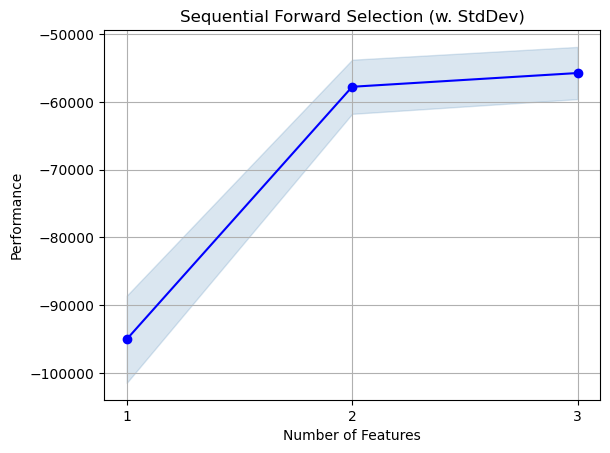

In [243]:
fig1 = plot_sfs(model.get_metric_dict(), kind='std_dev')
# plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

## Tune hyperparameters

Using leave one group out cross validation, where a group is a year.

In [244]:
parameters = {
    "n_estimators": randint(200, 500), # no. trees in the forest
    "min_samples_leaf": randint(5, 30), # min no. samples at leaf node
    "max_depth" : randint(5, 50), # max depth of each tree
    # "max_features" : uniform(0.2, 1) # max proportion of features to consider at split
    "max_leaf_nodes": randint(20, 100) # size of tree, how many end nodes
}

In [245]:
retain = ["demand"] + selected_features

In [246]:
final_features = df[retain]

In [247]:
final_features.head()

,demand,pred,is_weekend,month_int
2006-01-01,1.390770e+06,1.597828e+06,1,1
2006-01-02,1.558161e+06,1.644092e+06,0,1
2006-01-03,1.680000e+06,1.652778e+06,0,1
2006-01-04,1.723594e+06,1.671403e+06,0,1
2006-01-05,1.787870e+06,1.678984e+06,0,1


In [248]:
train_X, test_X, train_y, test_y = fn.split(
    sel_train_test(final_features, first_train_year, last_test_year),
    "demand",
    test_size=test_len,
    random_state=0,
    shuffle=False
)

In [249]:
# # very restricted space for testing
# parameters = {
#     "n_estimators": randint(10, 12), # no. trees in the forest
# }

In [250]:
rf = ExtraTreesRegressor()

In [251]:
logo = fn.leave_one_group_out(train_X, train_y, dem_da, str(first_train_year), str(last_train_year))

[2006 2006 2006 ... 2013 2013 2013]


In [252]:
%%time
best_params = fn.tune_hyperparameters(
    train_X,
    train_y,
    rf,
    parameters,
    logo,
    n_iter=200
)

CPU times: user 9min 58s, sys: 1.5 s, total: 9min 59s
Wall time: 9min 59s


In [253]:
best_params

{'max_depth': 8,
 'max_leaf_nodes': 62,
 'min_samples_leaf': 6,
 'n_estimators': 220}

## Finalise model

In [139]:
# # to save tuning hyperparameters again, copy and paste best_params here
# best_params = dict(
#     max_depth=29,
#     max_leaf_nodes=99,
#     min_samples_leaf=14,
#     n_estimators=474
# )

In [254]:
rf = ExtraTreesRegressor(
    n_estimators=best_params["n_estimators"],
    min_samples_leaf=best_params["min_samples_leaf"],
    max_depth=best_params["max_depth"],
    max_leaf_nodes=best_params["max_leaf_nodes"],
    random_state=0,
)

In [255]:
model_train, pred_train = fn.predict_forest(train_y, train_X, train_X, rf)

In [256]:
model_test, pred_test = fn.predict_forest(train_y, train_X, test_X, rf)

In [257]:
pred_train.shape

(2922,)

In [258]:
pred_test.shape

(1096,)

## Evaluate performance

In [259]:
train_scores = fn.compute_scores(train_y, pred_train, metrics)

In [260]:
train_scores

[0.9556024185448866,
 41005.65789348936,
 3151676172.695838,
 0.031763992230464166,
 30905.12581863854]

In [261]:
test_scores = fn.compute_scores(test_y, pred_test, metrics)

In [262]:
test_scores

[0.9392949815221872,
 43636.509143824325,
 3662613698.486468,
 0.034188055128647206,
 33091.760739602265]

In [263]:
def plot_scores(train, test, metric_names):
    """
    Subplot for each metric showing score for train and test.
    """
    fig, ax = plt.subplots(2, 3, figsize=(6, 3))
    for i, a in enumerate(ax.flatten()):
        if i < len(metric_names):
            a.bar(["Train", "Test"], [train[i], test[i]])
            a.set_title(metric_names[i])
    plt.tight_layout()

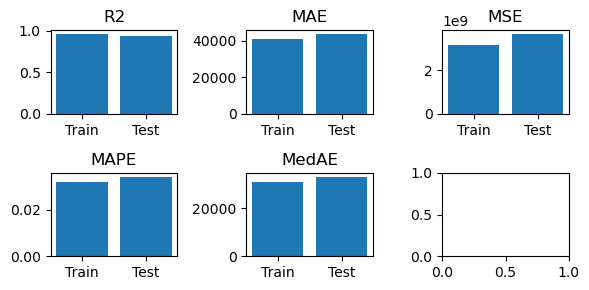

In [264]:
plot_scores(train_scores, test_scores, metric_names)

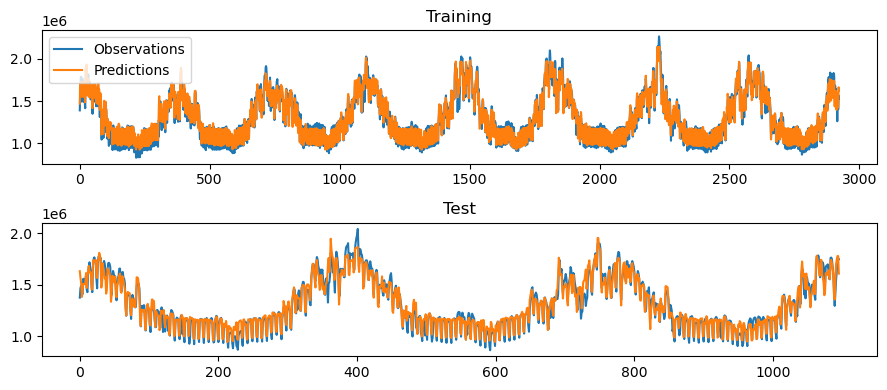

In [265]:
fig, ax = plt.subplots(2, 1, figsize=(9, 4))

ax[0].plot(train_y, label="Observations")
ax[0].plot(pred_train, label="Predictions")
ax[0].legend()
ax[0].set_title("Training")

ax[1].plot(test_y)
ax[1].plot(pred_test)
ax[1].set_title("Test")

plt.tight_layout()

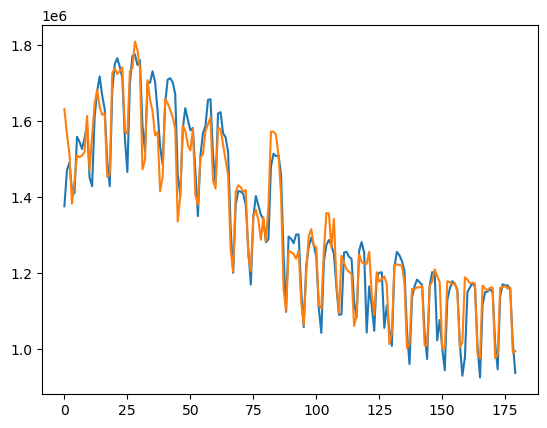

In [266]:
plt.plot(test_y[:180])
plt.plot(pred_test[:180])

# Note:

### The below are validation set results, where the training and test set results are predictions of predictions, not predictions of demand...

### And now on validation set

In [254]:
last_test_year

2016

In [276]:
time_cols = ["is_weekend"]

region_dfs = {}
for region in dem_da.region.values:
    df = fn.to_dataframe(dem_da, pred_ds, region)
    for t in time_cols:
        df = fn.add_time_column(df, t)
    new_cols = np.append(np.append("demand", time_cols), df.columns[:-(len(time_cols) + 1)])
    df = df[new_cols]
    region_dfs[region] = df

In [277]:
region_dfs[region]

,demand,is_weekend,msdwswrf,w10,t2m,cdd,hdd,rh,t2min,mtpr,q,t2max
2006-01-01,1.390770e+06,1,33.469701,2.968107,277.120854,-0.009722,11.013986,87.793425,274.126953,0.000044,4.606783,278.299142
2006-01-02,1.558161e+06,0,38.620781,2.234833,276.025270,-0.009723,12.109568,88.337877,272.778723,0.000021,4.223533,277.842970
2006-01-03,1.680000e+06,0,38.505117,1.849658,275.761280,-0.009725,12.373554,87.220708,272.670548,0.000014,4.090290,277.582042
2006-01-04,1.723594e+06,0,40.630597,2.490590,274.708175,-0.009727,13.426657,86.078723,271.983277,0.000009,3.725595,276.859842
2006-01-05,1.787870e+06,0,38.203008,2.962313,274.200237,-0.009729,13.934592,84.712166,271.639411,0.000008,3.543822,276.056212
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,1.679940e+06,0,40.692448,1.612725,275.848274,-0.018136,12.273452,87.795194,273.492140,0.000002,4.168545,279.485340
2018-12-28,1.669453e+06,0,38.997165,1.929787,276.401266,-0.018138,11.720458,89.504321,273.725989,0.000002,4.416365,279.349883
2018-12-29,1.591212e+06,1,36.062917,3.070928,277.571661,-0.018140,10.550060,88.539303,274.841585,0.000012,4.729524,280.415372
2018-12-30,1.501771e+06,1,36.289060,3.001991,278.441629,-0.018142,9.680090,86.732386,275.520617,0.000011,4.884352,280.783025


In [278]:
val_df = region_dfs[region][region_dfs[region].index.year > last_test_year][retain]

In [279]:
val_df

,demand,is_weekend,msdwswrf,w10,cdd,hdd,rh,t2min,mtpr
2017-01-01,1.659144e+06,1,44.670932,2.466691,-0.016850,14.462713,85.871348,271.221378,0.000020
2017-01-02,1.789642e+06,0,43.027224,2.444115,-0.016852,13.966171,87.167600,271.488706,0.000017
2017-01-03,1.905787e+06,0,40.617101,3.513182,-0.016854,13.115048,86.150884,271.946796,0.000022
2017-01-04,1.936445e+06,0,41.624294,3.887854,-0.016855,12.382174,82.299249,272.166419,0.000024
2017-01-05,1.904558e+06,0,52.568151,2.683660,-0.016857,14.971627,77.671090,269.595248,0.000013
...,...,...,...,...,...,...,...,...,...
2018-12-27,1.679940e+06,0,40.692448,1.612725,-0.018136,12.273452,87.795194,273.492140,0.000002
2018-12-28,1.669453e+06,0,38.997165,1.929787,-0.018138,11.720458,89.504321,273.725989,0.000002
2018-12-29,1.591212e+06,1,36.062917,3.070928,-0.018140,10.550060,88.539303,274.841585,0.000012
2018-12-30,1.501771e+06,1,36.289060,3.001991,-0.018142,9.680090,86.732386,275.520617,0.000011


In [280]:
val_y = val_df["demand"].values

In [281]:
val_y.shape

(730,)

In [283]:
val_X = np.array(val_df.drop("demand", axis=1))

In [284]:
val_X.shape

(730, 8)

In [285]:
model_test, pred_val = fn.predict_forest(train_y, train_X, val_X, rf)

In [286]:
pred_val.shape

(730,)

## Evaluate performance

In [287]:
val_scores = fn.compute_scores(val_y, pred_val, metrics)

In [288]:
val_scores

[0.8798333222182046,
 80679.3740568326,
 8998720766.88126,
 0.06330106762601136,
 72001.870730213]

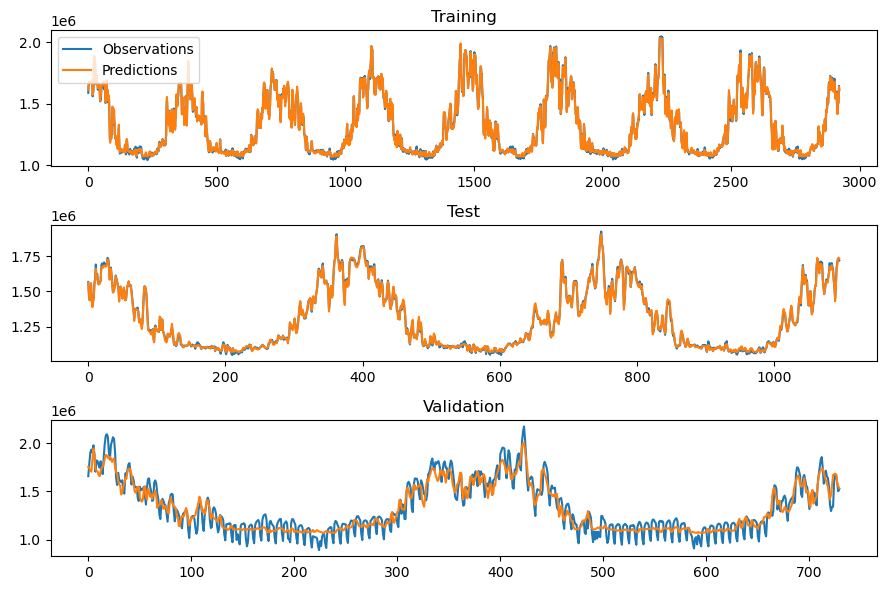

In [290]:
fig, ax = plt.subplots(3, 1, figsize=(9, 6))

ax[0].plot(train_y, label="Observations")
ax[0].plot(pred_train, label="Predictions")
ax[0].legend()
ax[0].set_title("Training")

ax[1].plot(test_y)
ax[1].plot(pred_test)
ax[1].set_title("Test")

ax[2].plot(val_y)
ax[2].plot(pred_val)
ax[2].set_title("Validation")

plt.tight_layout()